## Generator

In [0]:
%tensorflow_version 1.x

In [0]:
from tensorflow.keras.layers import Embedding, Flatten, Reshape, Dense, Concatenate, Conv2DTranspose, BatchNormalization, Activation, Input
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [0]:
?Reshape

In [0]:
# define the generator model
# 
# Reference - Paper : https://arxiv.org/pdf/1610.09585.pdf
# Also refer to GAN hacks - https://github.com/soumith/ganhacks
#
# For ACGAN:
#     inputs: label and noise (latent dimension)
#     ouput:  fake-image
#
# noise of size 8x8 -> 16x16 -> 32x32 -> 64x64
# label is also modeled as 8x8 - yet another channel along with noise
#
# Use ReLu instead of LeakyReLu for ACGAN - for more info refer to paper.
#
def generator(latent_dim, n_classes=2):

  # Input 1 - label - one dim tensor
  img_class = Input(shape=(1,))
  # use embedding for  input
  emb = Embedding(n_classes, latent_dim)(img_class)

  # setup the label as yet another channel along with noise
  n_nodes = 8 * 8
  label_in = Dense(n_nodes)(emb)
  # reshape it
  label_in = Reshape((8,8,1))(label_in)


  # Input 2 - noise
  latent_input = Input(shape=(latent_dim,))
  # foundation of noise input for image
  # refer to page 11 of the above mentioned paper for all these feature map count
  n_nodes = 398 * 8 * 8
  gen = Dense(n_nodes)(latent_input)
  gen = Activation('relu')(gen)
  gen = Reshape((8,8,398))(gen)

  # combine inputs : noise + label
  inp_merge = Concatenate()([gen, label_in])

  # upsample to 16x16
  gen = Conv2DTranspose(256, (5,5), strides=(2,2), padding='same')(inp_merge)
  gen = BatchNormalization()(gen)
  gen = Activation('relu')(gen)

  # upsample to 32x32
  gen = Conv2DTranspose(192, (5,5), strides=(2,2), padding='same')(gen)
  gen = BatchNormalization()(gen)
  gen = Activation('relu')(gen)

  # upsample to 64x64
  gen = Conv2DTranspose(3, (5,5), strides=(2,2), padding='same')(gen)
  # No BN - refer to page 11 of the above mentioned paper.

  # output
  out_layer = Activation('tanh')(gen)

  # define model
  model = Model([latent_input, img_class], out_layer)

  return model


In [4]:
latent_dim = 100
model_gen = generator(latent_dim)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [5]:
model_gen.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 25472)        2572672     input_2[0][0]                    
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 100)       200         input_1[0][0]                    
______________________________________________________________________________________________

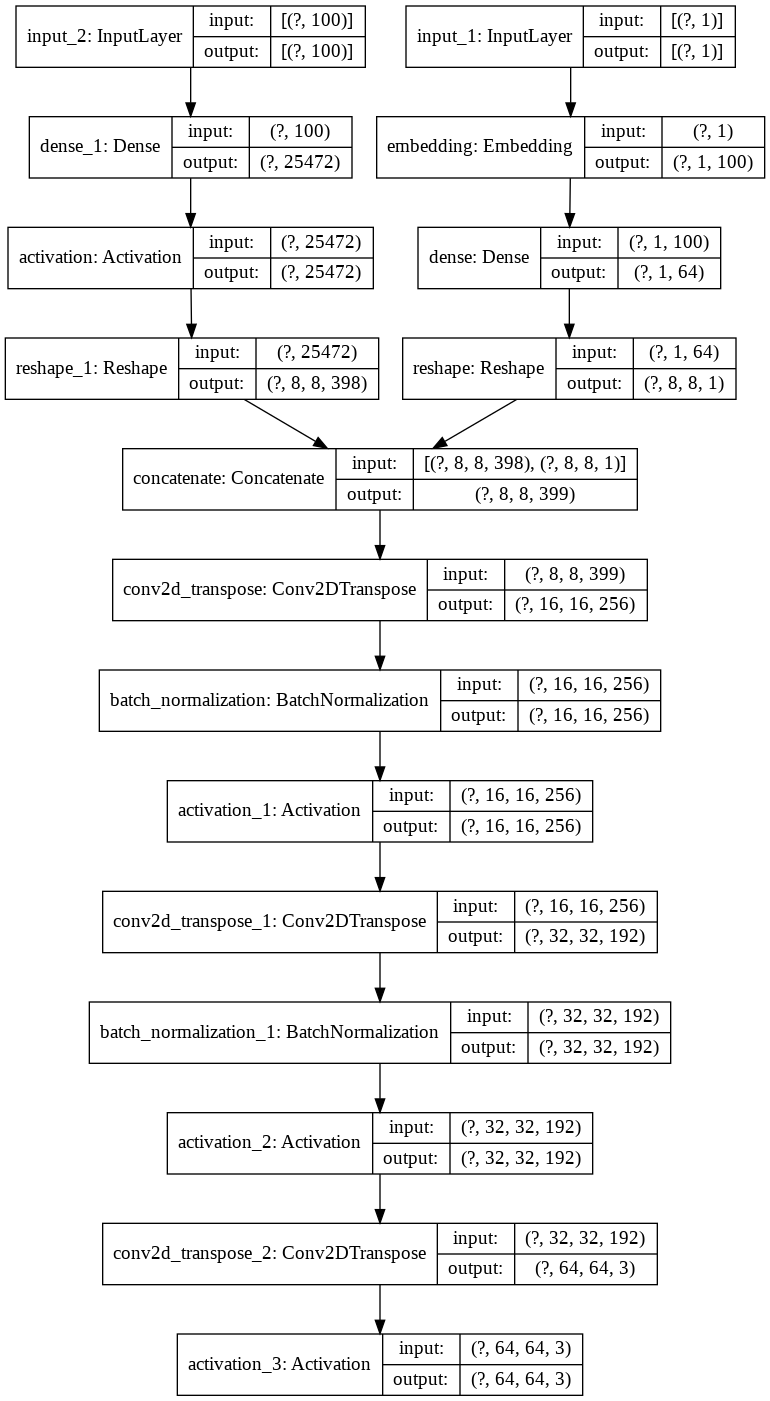

In [6]:
# plot the model
plot_model(model_gen, to_file= 'generator_plot.png' , show_shapes=True, show_layer_names=True)

## Generate Latent Points

Generate the latent space which is input to Generator

In [0]:
def generate_latent_points(latent_dim, n_samples, n_classes=2):
  # get the random points from normal distribution
  x_input = np.random.randn(latent_dim * n_samples)
  
  data = x_input.reshape(n_samples, latent_dim)
  # generate labels
  labels = np.random.randint(0, n_classes, n_samples)
  return [data, labels]

## Generate Fake Samples Using Generator
  * Inputs: Latent_dim
  * Outputs: images, labels and discriminator-class-label (realness value, ie 0 for fake)

In [0]:
def generate_fake_samples(generator, latent_dim, n_samples):
  # get the latent space
  data, labels_input = generate_latent_points(latent_dim, n_samples)

  # get the images and their labels
  images = generator.predict([data, labels_input])

  # tag them as fake (which is class 0 for discriminator)
  fake = np.zeros((n_samples, 1))

  return([images, labels_input], fake)


## Display Images From Generator

In [0]:
[fake_images, _], _ = generate_fake_samples(model_gen, latent_dim, 25)

In [10]:
fake_images.shape

(25, 64, 64, 3)

In [0]:
#fake_images[0]

In [0]:
# Generator uses tanh activation.
# convert the values from [-1, 1] to [0,1]
fake_images = (fake_images + 1) / 2.0

In [13]:
fake_images[0]

array([[[0.50043917, 0.4997514 , 0.49988723],
        [0.49997625, 0.50012374, 0.49945256],
        [0.50021076, 0.49912956, 0.49998832],
        ...,
        [0.49972466, 0.4998503 , 0.49800205],
        [0.49999186, 0.50021064, 0.49895498],
        [0.49992055, 0.5005445 , 0.4998373 ]],

       [[0.5003605 , 0.5005334 , 0.5000036 ],
        [0.5013227 , 0.50039685, 0.4993316 ],
        [0.498626  , 0.49938056, 0.5001542 ],
        ...,
        [0.5010288 , 0.5012914 , 0.49765828],
        [0.4997539 , 0.50069255, 0.5012689 ],
        [0.4999273 , 0.49950147, 0.4998881 ]],

       [[0.49982494, 0.49990416, 0.5000603 ],
        [0.49943548, 0.49953827, 0.49868894],
        [0.50058144, 0.4997462 , 0.50030994],
        ...,
        [0.49912322, 0.5021664 , 0.49976707],
        [0.49998257, 0.4999974 , 0.49931628],
        [0.5007624 , 0.50062555, 0.50042075]],

       ...,

       [[0.49985397, 0.49995774, 0.4998199 ],
        [0.500423  , 0.50196147, 0.4990849 ],
        [0.49845344, 0

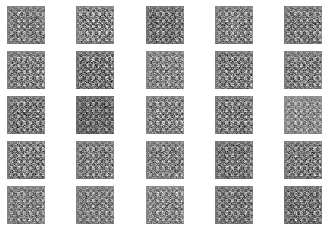

In [14]:
for i in range(25):
  plt.subplot(5,5, 1+i)
  plt.axis('off')
  #plt.imshow(fake_images[i])
  plt.imshow(fake_images[i, :, :, 0], cmap= 'gray_r' )


## Summarize Generator Performace

During training process measure the performace of Generator.
Just inspect the images the Generator generates at regular intervals and save the model as well.

In [0]:
# At regular intervals during training process
# generate images from generator
# and also, save model
#
def summarize_performance(step, gen_model, latent_dim, n_samples=25):
  # get the generated images
  [fake_images, _], _ = generate_fake_samples(model_gen, latent_dim, n_samples)

  # scale the images from [-1,1] to [0,1]
  fake_images = (fake_images + 1) / 2.0

  # plot images
  for i in range(25):
    plt.subplot(5, 5, 1+i)
    plt.axis('off')
    plt.imshow(fake_images[i])

  # save the plot to file
  filename = 'gen_plot_%04d.png' % (step+1)
  plt.savefig(filename)
  plt.close()

  # save the model as well
  model_file = 'gen_model_%04d.hdf5' % (step+1)
  gen_model.save(model_file)
  print('Saved: %s and %s' % (filename, model_file))